In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

# Import Libraries here
import os
import json 
import shutil
import zipfile

%reload_ext autoreload
%autoreload 2
%matplotlib inline

root_dir = "/home/"

# notebook project directories
base_dir = root_dir + 'ml/pcam/'
!mkdir -p "{base_dir}"

np.random.seed(2)

In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 64 bytes


In [3]:
# First we make sure we have the kaggle sdk installed.
# We assume here that on your machine you have the kaggle.json token file in ~/.kaggle/
!pip install kaggle 

# Extract data from Kaggle

In [4]:
#@title
# Can list available Kaggle competitions here if needed
#!kaggle competitions list

# PLease accept the rules before download otherwise you got the error message: "403 Forbidden"

# Download the histopathological data
!kaggle competitions download -c histopathologic-cancer-detection -p "{base_dir}"


  0% 0.00/1.33M [00:00<?, ?B/s]
100% 1.33M/1.33M [00:00<00:00, 43.9MB/s]
 98% 5.00M/5.10M [00:00<00:00, 10.3MB/s]
100% 5.10M/5.10M [00:00<00:00, 10.4MB/s]
 99% 1.29G/1.30G [00:35<00:00, 31.9MB/s]
100% 1.30G/1.30G [00:35<00:00, 39.7MB/s]
100% 4.97G/4.98G [02:23<00:00, 30.6MB/s]
100% 4.98G/4.98G [02:23<00:00, 37.3MB/s]


Unzip train data

In [5]:
#now unzip the training files
!mkdir -p "{base_dir}train/"
dest_dir_train = Path(base_dir + 'train/')
print(base_dir + 'train.zip')
train_zip = zipfile.ZipFile(base_dir + 'train.zip', 'r')
train_zip.extractall(dest_dir_train)
train_zip.close()

/home/ml/pcam/train.zip


unzip test data 

In [0]:
#now unzip the test files
!mkdir -p "{base_dir}test/"
dest_dir_test = Path(base_dir + 'test/')
test_zip = zipfile.ZipFile(base_dir + 'test.zip', 'r')
test_zip.extractall(dest_dir_test)
test_zip.close()
  

Unzip label data 

In [0]:
# then extract the labels 
dest_dir_csv = Path(base_dir)
labels_csv_zip = zipfile.ZipFile(base_dir + 'train_labels.csv.zip', 'r')
labels_csv_zip.extractall(dest_dir_csv)
labels_csv_zip.close()

Check download and extraction


In [8]:
# Check the download here
path = Path(base_dir)
path.ls()

[PosixPath('/home/ml/pcam/sample_submission.csv.zip'),
 PosixPath('/home/ml/pcam/test'),
 PosixPath('/home/ml/pcam/train_labels.csv.zip'),
 PosixPath('/home/ml/pcam/test.zip'),
 PosixPath('/home/ml/pcam/train_labels.csv'),
 PosixPath('/home/ml/pcam/train'),
 PosixPath('/home/ml/pcam/train.zip')]

# Data Preparation
With our data now downloaded, we create an *ImageDataBunch* object to help us load the data into our model, set data augmentations, and split our data into train and test sets.



In [0]:
tfms = get_transforms(do_flip=True)

In [0]:
bs=64 # also the default batch size
data = ImageDataBunch.from_csv(
    base_dir, 
    ds_tfms=tfms, 
    size=224, 
    suffix=".tif",
    folder="train", 
    test="test",
    csv_labels="train_labels.csv", 
    bs=bs)

In [11]:
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (176020 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
1,0,0,1,1
Path: /home/ml/pcam;

Valid: LabelList (44005 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,0,1,1,1
Path: /home/ml/pcam;

Test: LabelList (57458 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: /home/ml/pcam

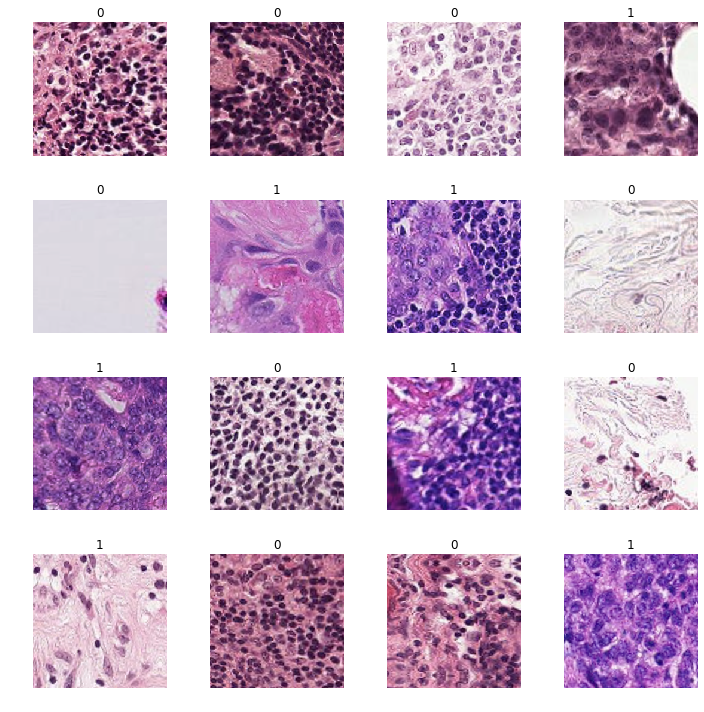

In [12]:
data.show_batch(rows=4, figsize=(10, 10))

In [15]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 346548656532732812, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 13731702285064326629
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 18237736741640699768
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 10921073050
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3302575082591281819
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [0]:
#Info a the GPU 
!nvidia-smi


# Learner (CNN Resnet50)
Once we have a correctly setup the ImageDataBunch object, we can now pass this, along with a pre-trained ImageNet model, to a cnn_learner. We will be using Resnet50 as our backbone.

In [16]:
# I am using a GPU that supports 16bit precision, so we also switch this support mode to on. 
# If your GPU does not have that support you can omit the to_fp16() call
learn = cnn_learner(data, models.resnet50, metrics=error_rate, callback_fns=ShowGraph).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
102502400it [00:01, 97228473.73it/s]


Fastai wraps up a lot of state-of-the-art computer vision learning in its cnn_learner:

Connects our pre-trained model with a layer group of fully connected layers.
- ReLU activations
- Batch normalisation
- Max pooling
- Drop out

Importantly, we also specify a backbone network, that has been pre-trained on the ImageNet dataset, so that we can use transfer learning in our training.

### Transfer learning
Starting with a backbone network from a well-performing model that was already pre-trained on another dataset is a method called transfer learning.

Transfer learning works on the premise that instead of training your data from scratch, you can use the learning (ie the learned weights) from another machine learning model as a starting point.

This is an incredibly effective method of training, and underpins current state-of-the-art practices in training deep neural networks.

When using pre-trained models we leverage, in particular, the learned features that are most in common with both the pre-trained model and the target dataset (PCam).

So for example, for models pre-trained on ImageNet such as Resnet50, training will leverage the common features (for example such as lines, geometry, patterns) that have already been learnt from the base dataset (in particular in the first few layers) to train on the target dataset.

For our model, we'll be using Resnet50. Resnet50 is a residual neural net trained on ImageNet data using 50 layers, and will provide a good starting point for our network.

Using *learn.model* we can see the various layers and elements of the neural network that are used.

In [19]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_s

## Training and fit one cycle
### Fit one cycle
We will be training our network with a method called fit one cycle. This optimisation is a way of applying a variable learning rate across the total number of epochs in our training run for a particular layer group. This has proven to be an extremely effective way to tune the learning rate hyperparamter for training.

Fit one cycle varies the learning rate from a minimum value at the first epoch (by default lr_max/div_factor), up to a pre-determined maximum value (lr_max), before descending again to a minimum across the remaining epochs. This min-max-min learning rate variance is called a cycle.

An excellent overview can be found here in the fastai docs https://docs.fast.ai/callbacks.one_cycle.html along with a more detailed explanation in the original paper by Leslie Smith [7], where this method of hyperparameter tuning was proposed.

So how then do we determine the most suitable maximum learning rate to enable fit one cycle? We run fastai's lr_find() method.

Running lr_find before unfreezing the network yields the graph below. We want to choose a learning rate just before the loss starts to exponetially increase.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


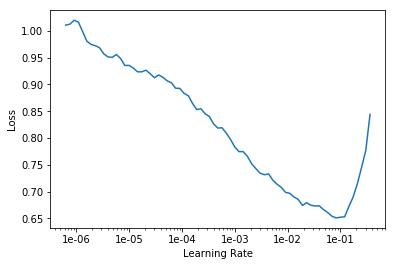

In [20]:
learn.lr_find()
learn.recorder.plot()

From a visual observation of the resulting learning rate plot, starting with a learning rate of 1e-02 seems to be a reasonable choice for an initial lr value.

### Freeze
By default we start with our network frozen. This means that the layers of our pre-trained Resnet50 model have trainable=False applied, and training begins only on the target dataset. The learning rate we provide to fit_one_cycle() applies only to that layer group for this initial training run

In [0]:
learn.fit_one_cycle(30, slice(1e-02))


epoch,train_loss,valid_loss,error_rate,time
